"**This set of codes looks at developing a recommender algorithm based on content based filtering. We evaluate the similarity of items by calculating their cosine similarity score from the latent features of the anime images obtained from a deep learning model which performs classification using the CNN features from ResNet50 transfer learning and predicting the topics generated from the synopsis.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import re

import os
import pickle
import timeit

## 1. Import Processed Images Data

In [2]:
images_squashed_dir = r'processed_data/images_squashed/'

In [3]:
# Get directory of resized images
file_names = os.listdir(images_squashed_dir)

# exclude the following files
excl_files = ['image_cosine_similarity.csv', 'image_index_names.csv', 'model2_results.txt', 'resnet50_features.npy', 'cnn_features_model2b.npy',
             'image_cosine_similarity_model2b.csv', 'image_index_names_model2b.csv', 'model2b_results.txt', 'model2bn_results.txt']
file_names = list(set(file_names) - set(excl_files))
len(file_names)

4801

In [4]:
# For each file name in directory append the matrix and name_index
anime_index = []
images = []

for i in file_names:
    img = Image.open(images_squashed_dir + i)
    anime_index.append(re.findall(r'\d+', i)[0]) 
    images.append(np.array(img))
    
# convert to numpy array    
full_data = np.array(images)

# convert anime index string to numbers
anime_index = [int(i) for i in anime_index]

In [5]:
# create df to sotre anime_index
df_img_label = pd.DataFrame({
    'anime_name_index': anime_index,
})
print(df_img_label.shape)

(4801, 1)


In [6]:
# import anime_meta data
meta_data = pd.read_csv(r'processed_data/processed_anime.csv')
meta_data.shape

(4808, 92)

In [7]:
# get the corresponding label of each data
df_img_label = df_img_label.merge(meta_data[['index', 'Dominant_Topic']], how='left', left_on='anime_name_index', right_on='index')
df_img_label.shape

(4801, 3)

In [8]:
df_img_label.head()

,anime_name_index,index,Dominant_Topic
0,5626,5626,2.0
1,13766,13766,0.0
2,4016,4016,3.0
3,14489,14489,2.0
4,5038,5038,2.0


In [9]:
# check topic classes
df_img_label['Dominant_Topic'].value_counts()

0.0    1298
2.0    1051
1.0     917
4.0     817
3.0     718
Name: Dominant_Topic, dtype: int64

In [10]:
# target label
y = df_img_label['Dominant_Topic'].astype(int).values
len(y)

4801

In [11]:
# check y
y[:5]

array([2, 0, 3, 2, 2])

In [12]:
# convert target label to one hot vector
values = y
n_values = np.max(y) + 1
y = np.eye(n_values)[y]
y[:5]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [13]:
# perform train test split for cnn classification task 
X_train, X_test, y_train, y_test = train_test_split(full_data, y, test_size = 0.2, random_state = 42)

In [14]:
print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of y_train: {}'.format(y_train.shape))
print('Shape of X_test: {}'.format(X_test.shape))
print('Shape of y_test: {}'.format(y_test.shape))


Shape of X_train: (3840, 224, 224, 3)
Shape of y_train: (3840, 5)
Shape of X_test: (961, 224, 224, 3)
Shape of y_test: (961, 5)


## 2. Using transfer learning from Resnet for Classification Task

Reference: https://stackoverflow.com/questions/65907365/tensorflow-not-creating-xla-devices-tf-xla-enable-xla-devices-not-set

We will use ResNet50 model with the weights that were initalized by imagenet. However, instead of taking the softmax layer of 1000 classes, we will remove that layer leaving the tightly condensed fully connected layer of 2048 neurons. Thereafter, we add a softmax layer to predict the topic model classes. The latent features will be extracted from the layer before the last dense layer. These latent features will be used for the cosine similarity comparison/

In [15]:
import tensorflow as tf
import math
from tensorflow.keras.layers import Input, Dropout, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import Model, load_model

In [16]:
# Get model
input_image = Input([224, 224, 3])
x = tf.cast(input_image, tf.float32)
x = tf.keras.applications.resnet.preprocess_input(x)
res50_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
res50_model.trainable = False
x = res50_model(x)
x = Dense(1024, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=[input_image], outputs=[x])

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [19]:
# Train model
epochs = 10
batch_size = 128

hist = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
30/30 [==============================] - 33s 780ms/step - loss: 0.6150 - accuracy: 0.2559 - val_loss: 0.4809 - val_accuracy: 0.3736
Epoch 2/10
30/30 [==============================] - 20s 666ms/step - loss: 0.4616 - accuracy: 0.4167 - val_loss: 0.4596 - val_accuracy: 0.3861
Epoch 3/10
30/30 [==============================] - 21s 720ms/step - loss: 0.4370 - accuracy: 0.4417 - val_loss: 0.4586 - val_accuracy: 0.3933
Epoch 4/10
30/30 [==============================] - 20s 675ms/step - loss: 0.4214 - accuracy: 0.4804 - val_loss: 0.4548 - val_accuracy: 0.4089
Epoch 5/10
30/30 [==============================] - 20s 680ms/step - loss: 0.4073 - accuracy: 0.5002 - val_loss: 0.4516 - val_accuracy: 0.4131
Epoch 6/10
30/30 [==============================] - 20s 684ms/step - loss: 0.3894 - accuracy: 0.5382 - val_loss: 0.4521 - val_accuracy: 0.4173
Epoch 7/10
30/30 [==============================] - 19s 642ms/step - loss: 0.3763 - accuracy: 0.5680 - val_loss: 0.4501 - val_accuracy: 0.4089

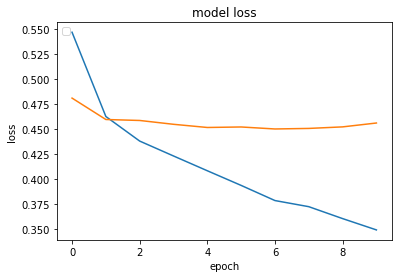

In [20]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

**Observations**
1. Overfitting issue - training loss decreases but validation loss increases after 5th epoch  
2. Limit to 5 epoch trainig. We are not concerned with the accuracy of this classification task since this is not our objective. Rather we just want to condition the latent features to be extracted to be based on topic models of the animes and not just purely based on image similarity.

In [22]:
# Retrain model based on epochs = 5
input_image = Input([224, 224, 3])
x = tf.cast(input_image, tf.float32)
x = tf.keras.applications.resnet.preprocess_input(x)
res50_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
res50_model.trainable = False
x = res50_model(x)
x = Dense(1024, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=[input_image], outputs=[x])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
epochs = 5
batch_size = 128

hist = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/5
30/30 [==============================] - 22s 682ms/step - loss: 0.6593 - accuracy: 0.2396 - val_loss: 0.4861 - val_accuracy: 0.3392
Epoch 2/5
30/30 [==============================] - 20s 675ms/step - loss: 0.4751 - accuracy: 0.3948 - val_loss: 0.4681 - val_accuracy: 0.3757
Epoch 3/5
30/30 [==============================] - 20s 668ms/step - loss: 0.4504 - accuracy: 0.4186 - val_loss: 0.4615 - val_accuracy: 0.3829
Epoch 4/5
30/30 [==============================] - 20s 669ms/step - loss: 0.4313 - accuracy: 0.4646 - val_loss: 0.4579 - val_accuracy: 0.3913
Epoch 5/5
30/30 [==============================] - 20s 673ms/step - loss: 0.4136 - accuracy: 0.4905 - val_loss: 0.4571 - val_accuracy: 0.3902


In [23]:
# get the last second dense layer
image_features_extractor = Model(inputs=model.input,  outputs=model.layers[-2].output)

In [24]:
embedded_vector =image_features_extractor.predict(full_data)

In [25]:
embedded_vector.shape

(4801, 1024)

## 3. Cosine similarity

In [26]:
# Calculate cosine similarity matrix
image_cosine = cosine_similarity(embedded_vector)

In [27]:
# Function to get top 10 similarity score with index
def get_similiarity(image_index_num, image_cosine, anime_index):
    # get index
    index = anime_index.index(image_index_num)
    
    # get similarity scores and index in tuples
    similar_scores = list(enumerate(image_cosine[index]))
    
    # sort the similarity scores with index
    similar_scores = sorted(similar_scores, key=lambda a: a[1], reverse=True)
    
    # top 10 similar animes tuples
    similar_scores = similar_scores[1:11]
    
    return similar_scores

In [31]:
sim_score = get_similiarity(3625, image_cosine, anime_index)

In [32]:
# get index of full_data and similarity score
sim_score

[(4178, 0.8206054),
 (2499, 0.8163633),
 (1650, 0.8117895),
 (2972, 0.8079019),
 (1942, 0.80262506),
 (2409, 0.79747665),
 (3295, 0.79545724),
 (960, 0.79432905),
 (3099, 0.7896526),
 (3895, 0.7891722)]

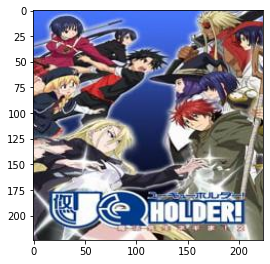

In [34]:
# visualize image
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(full_data[anime_index.index(3625), :, :, :]);

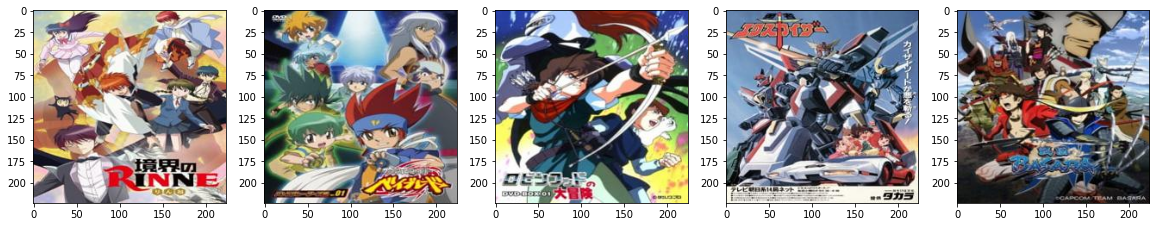

In [35]:
# plot top 5
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,5,1)
ax1.imshow(full_data[sim_score[0][0], :, :, :])
ax2 = fig.add_subplot(1,5,2)
ax2.imshow(full_data[sim_score[1][0], :, :, :])
ax3 = fig.add_subplot(1,5,3)
ax3.imshow(full_data[sim_score[2][0], :, :, :])
ax4 = fig.add_subplot(1,5,4)
ax4.imshow(full_data[sim_score[3][0], :, :, :])
ax5 = fig.add_subplot(1,5,5)
ax5.imshow(full_data[sim_score[4][0], :, :, :]);

**Get the meta data of animes**

In [36]:
meta_data = pd.read_csv(r'processed_data/processed_anime.csv')
meta_data.shape

(4808, 92)

In [40]:
# get 10 random sample anime index names
import random
random.seed(2345)

# get 10 anime index names.
sample_name = random.sample(anime_index, 10)

sample_name

# manually change to index between 0 to 9. 
sample_pick = sample_name[4]

In [41]:
# get reference image data
meta_data[meta_data['index'] == sample_pick][['index', 'Title', 'URL', 'Synonyms', 'Genres', 'Rating', 'Score', 'Ranked', 'Synopsis', 'anime_uid']]

,index,Title,URL,Synonyms,Genres,Rating,Score,Ranked,Synopsis,anime_uid
4668,15773,Osananajimi ga Zettai ni Makenai Love Comedy,https://myanimelist.net/anime/43007/Osananajim...,The Romcom Where The Childhood Friend Won't Lo...,"['Harem', 'Comedy', 'Romance', 'School']",None,NaN,NaN,My childhood friend Shida Kuroha seems to have...,43007


In [42]:
# get similar anime meta data
sample_names = [anime_index[i[0]] for i in sim_score]

In [43]:
meta_data.set_index('index').loc[sample_names].reset_index()[['index', 'Title', 'URL', 'Synonyms', 'Genres', 'Rating', 'Score', 'Ranked', 'Synopsis', 'anime_uid']]

,index,Title,URL,Synonyms,Genres,Rating,Score,Ranked,Synopsis,anime_uid
0,4081,Kyoukai no Rinne (TV),https://myanimelist.net/anime/28423/Kyoukai_no...,NaN,"['Comedy', 'Supernatural', 'Romance', 'School'...",PG-13 - Teens 13 or older,6.89,#4082,A very strange thing happened to Mamiya Sakura...,28423
1,5023,Metal Fight Beyblade,https://myanimelist.net/anime/5962/Metal_Fight...,Beyblade: Metal Fusion,"['Adventure', 'Comedy', 'Sports']",PG - Children,6.68,#5024,A new cast of characters take on the continued...,5962
2,3105,Robin Hood no Daibouken,https://myanimelist.net/anime/2543/Robin_Hood_...,NaN,"['Adventure', 'Historical', 'Romance']",G - All Ages,7.12,#3106,A variant of Robin Hood in which all the princ...,2543
3,5784,Yuusha Exkaiser,https://myanimelist.net/anime/3325/Yuusha_Exka...,Brave Exkaiser,"['Action', 'Mecha', 'Sci-Fi', 'Shounen']",G - All Ages,6.52,#5784,"When aliens plan to invade earth, the young Ko...",3325
4,1958,Sengoku Basara,https://myanimelist.net/anime/5355/Sengoku_Basara,NaN,"['Action', 'Historical', 'Martial Arts', 'Samu...",PG-13 - Teens 13 or older,7.39,#1959,"During Japan's Sengoku period, several powerfu...",5355
5,243,Major S1,https://myanimelist.net/anime/627/Major_S1,NaN,"['Comedy', 'Sports', 'Drama', 'Shounen']",PG-13 - Teens 13 or older,8.28,#244,"Gorou Honda, a little boy obsessed with baseba...",627
6,3074,Kenyuu Densetsu Yaiba,https://myanimelist.net/anime/2335/Kenyuu_Dens...,NaN,"['Action', 'Comedy', 'Fantasy', 'Martial Arts'...",PG-13 - Teens 13 or older,7.13,#3075,Kurogane Yaiba is a boy who doesn't want to be...,2335
7,738,InuYasha,https://myanimelist.net/anime/249/InuYasha,Inu Yasha,"['Action', 'Adventure', 'Comedy', 'Historical'...",PG-13 - Teens 13 or older,7.85,#739,Based on the Shogakukan award-winning manga of...,249
8,8341,Chou Kousoku Galvion,https://myanimelist.net/anime/6636/Chou_Kousok...,Cho Kosoku Galvion,"['Action', 'Sci-Fi', 'Police', 'Mecha']",PG-13 - Teens 13 or older,5.96,#8342,Super High Speed Galvion features mecha design...,6636
9,963,Mobile Suit Gundam Wing,https://myanimelist.net/anime/90/Mobile_Suit_G...,"New Mobile Report Gundam Wing, Shin Kidou Senk...","['Action', 'Military', 'Sci-Fi', 'Space', 'Dra...",PG-13 - Teens 13 or older,7.73,#964,The United Earth Sphere Alliance is a powerful...,90


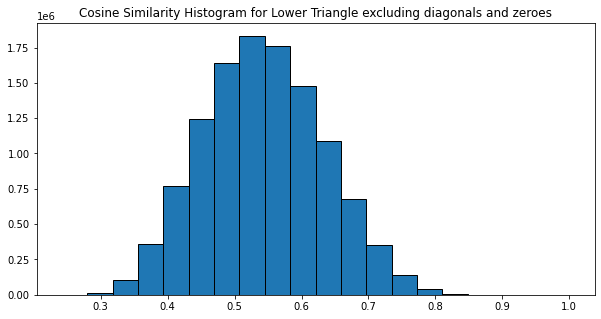

In [44]:
# take lower half of cosine similarity, excluding the diagonals
lower_tri = np.tril(image_cosine, -1)
lower_tri = lower_tri.reshape(-1)

# remove all zeros
lower_tri = lower_tri[lower_tri != 0]

# plot distribution of cosine similarity matrix
fig = plt.figure(figsize=(10,5))
plt.hist(lower_tri, bins=20, ec='black')
plt.title('Cosine Similarity Histogram for Lower Triangle excluding diagonals and zeroes');

## 4. Save the similarity matrix and indices

In [45]:
matrix_index = [i[0] for i in enumerate(anime_index)]

In [46]:
index_names = pd.DataFrame({
    'matrix_index': matrix_index,
    'anime_name_index': anime_index
})

In [47]:
index_names.head()

,matrix_index,anime_name_index
0,0,5626
1,1,13766
2,2,4016
3,3,14489
4,4,5038


In [48]:
# fetch in corresponding anime_uid
index_names = index_names.merge(meta_data[['index', 'anime_uid']], how='left',  left_on='anime_name_index', right_on='index')
index_names.head()

,matrix_index,anime_name_index,index,anime_uid
0,0,5626,5626,5534
1,1,13766,13766,31746
2,2,4016,4016,40763
3,3,14489,14489,3414
4,4,5038,5038,260


In [49]:
matrix = pd.DataFrame(image_cosine, index=index_names['anime_uid'], columns=index_names['anime_uid'])

In [50]:
matrix.head()

anime_uid,5534,31746,40763,3414,260,31733,12875,5034,37379,5027,...,38585,23277,37509,1675,1932,782,3407,30826,29527,20233
anime_uid,,,,,,,,,,,,,,,,,,,,,
5534,1.000000,0.658220,0.664895,0.743401,0.456430,0.603268,0.536749,0.523639,0.585426,0.743842,...,0.537951,0.496704,0.469736,0.422400,0.756526,0.483397,0.360185,0.566034,0.528097,0.712472
31746,0.658220,1.000000,0.625422,0.732290,0.469015,0.578795,0.562493,0.500806,0.567335,0.686648,...,0.458033,0.494380,0.448958,0.507075,0.683414,0.503586,0.399218,0.564442,0.480063,0.567063
40763,0.664895,0.625422,1.000000,0.615445,0.546137,0.729303,0.532308,0.631072,0.622968,0.647150,...,0.673441,0.593529,0.488039,0.613755,0.679063,0.537700,0.511206,0.586247,0.481528,0.575520
3414,0.743401,0.732290,0.615445,1.000000,0.369913,0.560751,0.448422,0.463579,0.468185,0.672320,...,0.476847,0.419667,0.375148,0.423739,0.662274,0.400667,0.341387,0.479077,0.490148,0.678533
260,0.456430,0.469015,0.546137,0.369913,1.000000,0.553138,0.601759,0.642532,0.589862,0.477595,...,0.528001,0.570338,0.663392,0.474244,0.488413,0.570800,0.644893,0.560289,0.468288,0.433940


In [51]:
# save files
matrix.to_csv(r'processed_data/images_squashed/image_cosine_similarity_model2b.csv', header=False, index=False)
index_names.to_csv(r'processed_data/images_squashed/image_index_names_model2b.csv', header=True, index=False)
np.save(r'processed_data/images_squashed/cnn_features_model2b.npy', np.array(embedded_vector))

## 6. Calculate Prediction Ratings

With the cosine similarity score, we can calculate the predicted rating for every user.  
The steps to do so are summarised below:  
1. Split reviews data into train and test data  
2. For every user in the train dataset, we identify the animes which have been watched by the user and animes which have not been watched by the user. We used rating as a proxy of whether user had watched the anime. 
3. Thereafter, we compute the predicted rating for Item i for User by applying the formula:  
$\hat{P}_{u,i} = \frac {\sum \limits _{m \in I} (r_{u,m} * s_{i,m})} {\sum \limits _{m \in I} s_{i,m}}  $  
4. Based on the predicted ratings, we identify Top 10 items to be recommended to user and compute the hit rate by comparing it against the test dataset.


**import dataset**

In [52]:
df_review = pd.read_csv('processed_data/processed_reviews.csv')
df_review.shape

(75921, 7)

In [53]:
# subset reviews for animes within scope
df_review = df_review[df_review['anime_uid'].isin(index_names['anime_uid'].tolist())]
print(len(df_review))

75921


In [54]:
df_review.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

In [55]:
# check the distribution of ratings
df_review['score'].describe()

count    75921.000000
mean         7.353038
std          2.219829
min          0.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: score, dtype: float64

**a. Train Test Split**

Apply the leave-one-out methodology to do train-test split. For each user, the most recent review is used as the test set. The most recent review is indicated by the larger uid. The reamining ratings would be used in the train dataset. This will help to ensure no data leakage.

In [56]:
# create test dataset
test = df_review.loc[df_review.groupby('profile')['uid'].idxmax()]
test.shape

(15363, 7)

In [57]:
# create train dataset
train = df_review[~(df_review['uid'].isin(test['uid'].tolist()))]
train.shape

(60558, 7)

**b. Identify animes which have been watched by users as well as those which have not been watched by users**

In [58]:
# create a unique list of anime_uid
anime_uid = list(set(index_names['anime_uid'].tolist()))
len(anime_uid)

4801

In [59]:
# create a unique list of profiles from train dataset
profile_list = list(set(train['profile'].tolist()))
len(profile_list)

15363

In [60]:
# identify list of animes watched 
# identify the list of animes not watched. As the not watched list is huge, 
# we randomly sample 99 animes not watched items + the one watched item in the test data to form the not watched list.
# we repeat this random sampling 10 times to ensure robustness while accounting for limited computational resource.

watched_list = []
not_watched_list_1 = []
not_watched_list_2 = []
not_watched_list_3 = []
not_watched_list_4 = []
not_watched_list_5 = []

for user in profile_list:
    
    # subset watched animes - i.e. those with ratings
    u_watched = train[train['profile']==user]['anime_uid'].tolist()
    watched_list.append(u_watched)
    
    # identify animes not watched i.e. those without ratings
    u_not_watched = list(set(anime_uid) - set(u_watched) - set(test[test['profile']==user]['anime_uid'].tolist()))
    
    # set seed to control reproducibility of sampling
    random.seed(2345)
    u_not_watched_1 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_1.append(u_not_watched_1)
    
    random.seed(2346)
    u_not_watched_2 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_2.append(u_not_watched_2)
    
    random.seed(2347)
    u_not_watched_3 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_3.append(u_not_watched_3)
    
    random.seed(2348)
    u_not_watched_4 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_4.append(u_not_watched_4)
    
    random.seed(2349)
    u_not_watched_5 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_5.append(u_not_watched_5)


In [61]:
# check len of watched_list and not watched list
print(len(watched_list))
print(len(not_watched_list_1))
print(len(not_watched_list_5))

15363
15363
15363


In [62]:
# check 
print(len(watched_list[0]))
print(len(not_watched_list_1[0]))
print(len(not_watched_list_5[0]))

2
100
100


**c. Compute the predicted ratings for not watched list for each user**

In [63]:
# Create a function to compute the predicted ratings for not watched list for each user

def predict_ratings(profile, not_watched, train_dataset, sim_matrix):
    
    '''
    Args:
        profile - list of unique profiles
        not_watched - list of not watched animes for all users
        train_dataset - train data
        sim_matrix - matrix capturing the cosine similarity between every pair of anime x and anime y
    
    Returns:
        predicted_ratings - nested list of predicted ratings for each user

    '''
    
    # initialise list to store predictions
    predicted_rating = []
    
    for i in range(len(profile)):
        
        # subset the ratings for watched animes
        watched_animes_ratings = train_dataset[train_dataset['profile']==profile[i]][['score', 'anime_uid']].sort_values(by=['anime_uid'])
    
        # initialise list to store ratings for user
        individual_ratings = []
    
        # subset animes not watched for user
        animes = not_watched[i]
        #print(len(animes))
    
        # iterate through every anime not watched
        for k in animes:          
            
            # subset the cosine similarity vector between anime and watched animes
            cos_sim_subset = sim_matrix[k]
            cos_sim_subset = cos_sim_subset[(cos_sim_subset.index.isin(animes)) | 
                                             (cos_sim_subset.index.isin(watched_animes_ratings['anime_uid'].tolist()))]
            total_sim_score = sum(cos_sim_subset)
            cos_sim_subset = cos_sim_subset[cos_sim_subset.index.isin(watched_animes_ratings['anime_uid'].tolist())]
            cos_sim_subset = cos_sim_subset.sort_index(ascending=False)
        
            # compute predicted ratings
            for x, y in zip(cos_sim_subset, watched_animes_ratings['score']):
                predictions = np.sum(np.dot(x,y))/total_sim_score
            
            individual_ratings.append(predictions)
    
        #print(len(individual_ratings))
        predicted_rating.append(individual_ratings)
    
    return predicted_rating


In [64]:
# Generate predict ratings based on the different sets of randomly sampled 100 not watched animes for each user

start_time = timeit.default_timer()

predicted_ratings_1 = predict_ratings(profile_list, not_watched_list_1, train, matrix)
print('done')
predicted_ratings_2 = predict_ratings(profile_list, not_watched_list_2, train, matrix)
print('done')
predicted_ratings_3 = predict_ratings(profile_list, not_watched_list_3, train, matrix)
print('done')
predicted_ratings_4 = predict_ratings(profile_list, not_watched_list_4, train, matrix)
print('done')
predicted_ratings_5 = predict_ratings(profile_list, not_watched_list_5, train, matrix)
print('done')

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)

done
done
done
done
done
Time taken: 3718.8728016


**d. Evaluate Hit Rate @ 10 for Proposed Recommender**

In [65]:
# create function to evaluate hit rate @ 10

def hit_rate(predictions, not_watched, test_dataset, profile):
    
    '''
    Args:
        predictions - nested list of predicted ratings of every user for the 100 animes randomly sampled
        not_watched - nested list of 100 animes not watched for each user
        test_dataset - test data
        profile - list of unique profiles
    
    Returns:
        hit_rate - hit rate @ 10
        top_10_animes - nested list of top 10 ainmes recommended for each user 
    '''
    
    top_10_animes = []
    hit = 0
    
    for i in range(len(predictions)):
    
        user = profile[i]
    
        # get the top 10 animes recommended to user
        top_10_idx = np.argsort(predictions[i])[-10:]
        top_10_animes = [not_watched[i][k] for k in top_10_idx]
    
        # check if the test data is found in the proposed top 10 recommended animes
        anime_watched = test_dataset[test_dataset['profile']==user]['anime_uid']

        if anime_watched.values in top_10_animes:
            hit += 1
        else:
            hit = hit
    
    hit_rate = round((hit/len(profile))*100,2)
    
    return top_10_animes, hit_rate

In [66]:
# Generate hit rate @ 10 for the different samples

start_time = timeit.default_timer()

top_10_animes_1, hit_rate_1 = hit_rate(predicted_ratings_1, not_watched_list_1, test, profile_list)
top_10_animes_2, hit_rate_2 = hit_rate(predicted_ratings_2, not_watched_list_2, test, profile_list)
top_10_animes_3, hit_rate_3 = hit_rate(predicted_ratings_3, not_watched_list_3, test, profile_list)
top_10_animes_4, hit_rate_4 = hit_rate(predicted_ratings_4, not_watched_list_4, test, profile_list)
top_10_animes_5, hit_rate_5 = hit_rate(predicted_ratings_5, not_watched_list_5, test, profile_list)

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)


Time taken: 76.13899429999992


In [67]:
# print hit rates
print('Hit Rate @ 10 based on not_watched_list_1: {}%'.format(hit_rate_1))
print('Hit Rate @ 10 based on not_watched_list_2: {}%'.format(hit_rate_2))
print('Hit Rate @ 10 based on not_watched_list_3: {}%'.format(hit_rate_3))
print('Hit Rate @ 10 based on not_watched_list_4: {}%'.format(hit_rate_4))
print('Hit Rate @ 10 based on not_watched_list_5: {}%'.format(hit_rate_5))


Hit Rate @ 10 based on not_watched_list_1: 19.45%
Hit Rate @ 10 based on not_watched_list_2: 18.79%
Hit Rate @ 10 based on not_watched_list_3: 19.14%
Hit Rate @ 10 based on not_watched_list_4: 17.93%
Hit Rate @ 10 based on not_watched_list_5: 19.31%


In [68]:
# print avg hit rates
avg_hit_rate = (hit_rate_1 + hit_rate_2 + hit_rate_3 + hit_rate_4 + hit_rate_5)/5 
print('Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list: {}%'.format(avg_hit_rate))


Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list: 18.924%


In [69]:
# save the results
hit_rates_all = [hit_rate_1, hit_rate_2, hit_rate_3, hit_rate_4, hit_rate_5, avg_hit_rate]

with open("processed_data/images_squashed/model2bn_results.txt", "wb") as fp:   
    pickle.dump((predicted_ratings_1, predicted_ratings_2, predicted_ratings_3, predicted_ratings_4, predicted_ratings_5, \
                not_watched_list_1, not_watched_list_2, not_watched_list_3, not_watched_list_4, not_watched_list_5, \
                 top_10_animes_1, top_10_animes_2, top_10_animes_3, top_10_animes_4, top_10_animes_5, hit_rates_all, \
                watched_list, profile_list), fp)
